# Feature selection with Random Forests

**Limitations:** 
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
- Random Forests give preference to features with high cardinality

In [47]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from random import randint 

# Data loading and preprocessing

In [48]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset = pd.read_csv('train.csv')

In [49]:
# label as integer
label = "Class"

classes = dataset[label].unique().tolist()
print(f"Label classes: {classes}")

dataset[label] = dataset[label].map(classes.index)

Label classes: [1, 0]


In [50]:
#convert EJ to dummy for PCA
ej_dummy = pd.get_dummies(
    dataset['EJ'],prefix='EJ', dtype=int)

dataset = pd.concat(
    [dataset,ej_dummy],
    axis=1
)

#drop ID and EJ
dataset = dataset.drop(['Id','EJ'], axis=1)

In [51]:
# outcome 
y = dataset['Class'].values

# features 
X = dataset[[i for i in dataset.columns if i not in ['Class']]].values

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

# train and test dataframes 
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
train_df.columns=['Class','AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC',
                  'BD ', 'BN', 'BP','BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF',
                  'CH', 'CL', 'CR', 'CS', 'CU','CW ', 'DA', 'DE', 'DF', 'DH',
                  'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH',
                  'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR','FS',
                  'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B']

# assign names to test_df
test_df.columns = train_df.columns

In [52]:
# Find which columns have missing values
sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]


#sum_null = test_df.isnull().sum()
#sum_null[sum_null!=0]

BQ    53
CC     1
DU     1
EL    52
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [53]:
mean_values = train_df.mean()
filled_df = train_df.fillna(mean_values, inplace=False)
train_df = filled_df

sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [54]:
mean_values = train_df.mean()
filled_df = test_df.fillna(mean_values, inplace=False)
test_df = filled_df

sum_null = test_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [55]:
# X_train, y_train, X_test, y_test
columns = [i for i in dataset.columns if i not in ['Class']]

y_train = train_df[label].values
y_test = test_df[label].values

X_train = train_df[columns].values
X_test = test_df[columns].values


print(type(train_df),type(test_df))

# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape,'\nShape y_test:', y_test.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
Shape X_train:  (493, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (493,) 
Shape y_test: (124,)


# Build the model

In [56]:
# Weight the classes
neg, pos = np.bincount(train_df['Class'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.90
Weight for class 1: 0.60


# Fit the model

In [57]:
rf = RandomForestClassifier(class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', oob_score=True, random_state=42)

# Evaluate the model

In [58]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = -np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases
    log_loss_1 = -np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

In [59]:
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': make_scorer(balanced_log_loss, greater_is_better=False)
}

scores = cross_validate(rf, X_train, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss: Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss: Mean: %0.2f Standard deviation: %0.2f" % (scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc: Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc: Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))



Training balanced log loss: Mean: 0.00, Standard deviation: 0.00
Validation balanced log loss: Mean: -0.21 Standard deviation: 0.28
--------------------------------------------------
Training balanced roc_auc: Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc: Mean: 0.95 Standard deviation: 0.06


# Hyperparameter tuning

In [60]:
hyperparameter_space = {'n_estimators': [100,200, 300,400,5000], #number of trees default=100
                         'max_depth': [3, 6, 9]} #depth of trees

# Exhaustive search over specified parameter values for an estimator.
gs = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10,n_jobs=-1, scoring='roc_auc', refit=False) 

gs.fit(X_train, y_train)
print("Optimal hyperparameter combination: ", gs.best_params_)

Optimal hyperparameter combination:  {'max_depth': 9, 'n_estimators': 300}


In [61]:
# refit with best parameters
rf_best = RandomForestClassifier(n_estimators=300,max_depth=9,class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')
rf_best.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=300,
                       oob_score=True, random_state=42)

# Feature importance based on feature permutation


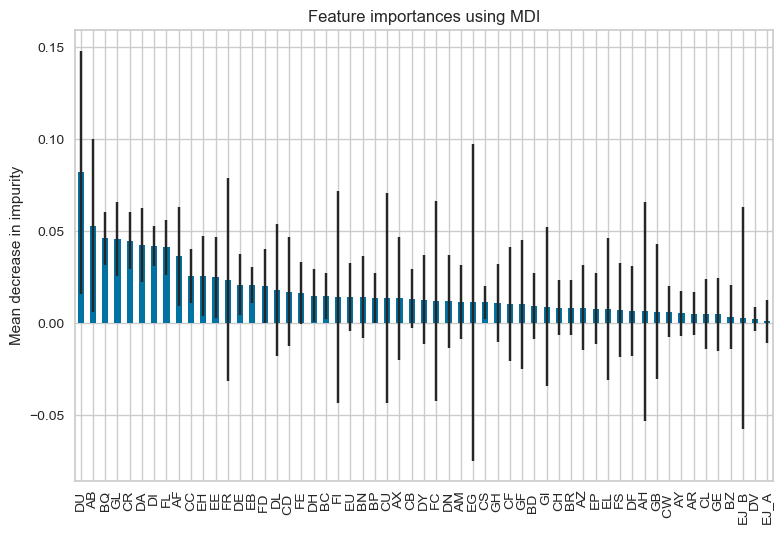

In [62]:
importances = rf_best.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances, index=columns)
forest_importances_sorted = forest_importances.sort_values(ascending=False)


fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Check correlation between top 39 variables with highest decrease in impurity 
(this number is given by the number of features that explain 95% of the variance, per PCA)

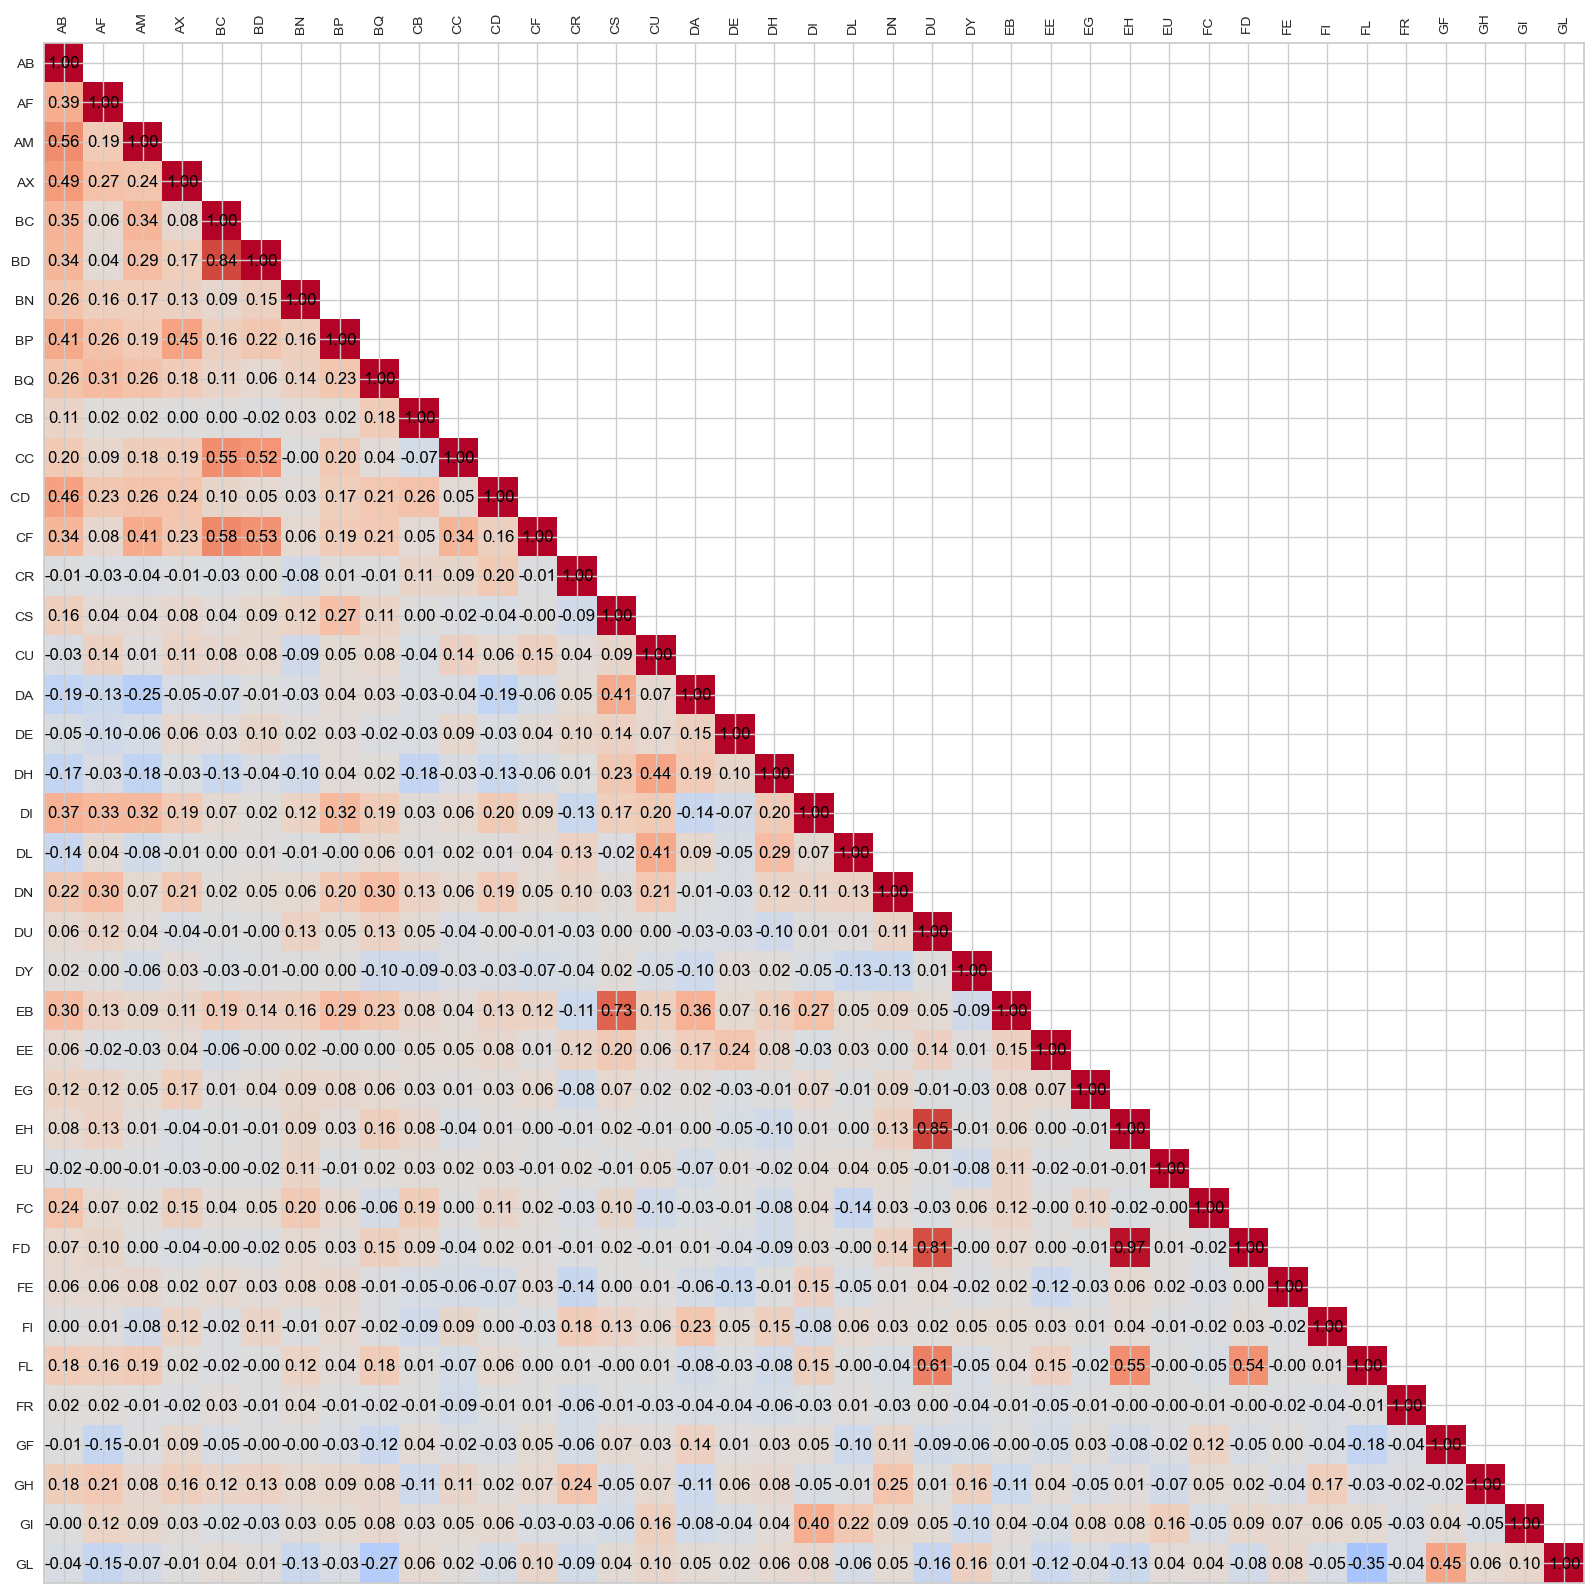

In [110]:
#select top variables
top = forest_importances_sorted[0:39]
df = top.to_frame().reset_index()

# convert into pandas df for correlation
df.columns=['Feature', 'Correlation']
pivot_df = df.pivot_table(index=None, columns='Feature', values='Correlation', aggfunc='mean')

# correlations
FEATURE_COLUMNS = pivot_df.columns
feature_train_df = train_df[FEATURE_COLUMNS]
corr = feature_train_df.corr()

#heatmap 
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)

# Create a mask for the upper triangle
mask = np.triu(np.ones(corr.shape), k=1)

# Set the upper triangle of the correlation matrix to a specific color (white in this case)
corr = corr.where(mask == 0)

# Create the heatmap
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
# fig.colorbar(cax)

ticks = np.arange(0, len(feature_train_df.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(feature_train_df.columns)
ax.set_yticklabels(feature_train_df.columns)

# Annotate the correlation values on the heatmap
for i in range(len(feature_train_df.columns)):
    for j in range(len(feature_train_df.columns)):
        if mask[i, j] == 0:  # Display text only for the lower triangular part
            text = "{:.2f}".format(corr.iloc[i, j])  # Format the correlation value to two decimal places
            ax.text(j, i, text, ha='center', va='center', color='black')

plt.show()



# Conclusion: which features should be selected?

- The features with the highest decrease in impurity are: DU, AB, BQ, GL, CR, DA, DI, FL, AF, CC, EH, EE, FR, DE, EB, FD, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI
- However, DU is is highly correlated with EH (0.85) FD (0.81) and somewhat with FL (0.65).
- EH and FD are very highly correlated (0.97).
- CS and EB (0.73).
- BD and BC (0.84).

So it might be a good idea to drop the features which are highly correlated with DU, seeing as DU is the feature with highest decrease in impurity, *as well as one of the features in each highly correlated pair (CS/EB  and BD/BC)*?

**Suggested features for input:**
DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI

